# Understanding LIME for Images

In this notebook, I'm trying to understand how [LIME](https://arxiv.org/pdf/1602.04938.pdf) (Local Interpretable Model-agnostic Explainer) works for images.

This is what you can do with LIME:

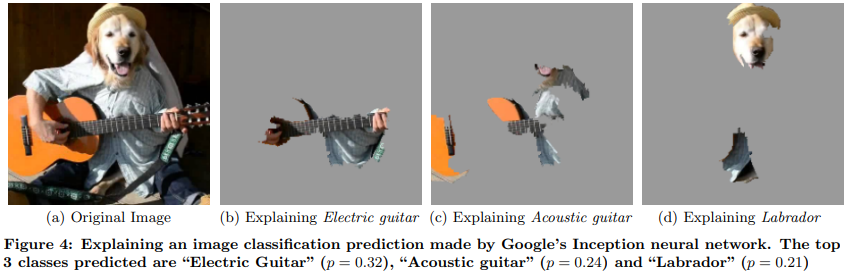

Source: https://arxiv.org/pdf/1602.04938.pdf


## Links

* LIME paper: ["Why Should I Trust You?" Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)
* LIME Python implementation: https://github.com/marcotcr/lime
* Third-party explanations of LIME
    * https://ema.drwhy.ai/LIME.html#ref-imlRPackage
    * https://christophm.github.io/interpretable-ml-book/lime.html

In [46]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
from tqdm import trange
import os
import pandas as pd
from PIL import Image

We want to explain how a blackbox model classifies an image, so we first need such a model.

We load a pre-trained blackbox neural network. We use Google's **InceptionV3** neural network that was trained on the [ImageNet](https://de.wikipedia.org/wiki/ImageNet) dataset. ImageNet consists of 14.197.122 labeled images, each belonging to one of 1000 classes.

In [2]:
model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [3]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

We're trying to replicate the results of the LIME paper. In the paper, the authors want to know how Google's Inception neural network classifies the image below. This image should be hard to classify for the network. Some areas of the image suggests that the image label is "labrador". Other areas of the image suggest that the image label is "guitar". Others suggest that the image label is "human".

If the model predicts "labrador", we want to know why. Precisely, we want to know *which pixels or group of pixels made the neural network predict label 'labrador'?*.

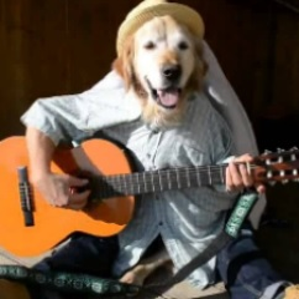

In [5]:
img_path = "imagenet-samples"
img_name = "test.jpg"
img = Image.open(os.path.join(img_path, img_name))

# reshape image to match input layer dimensions of InceptionV3
w, h = 299, 299
img = img.resize((w, h)) 
img

First, we want to know what label the pre-trained InceptionV3 model would predict for the image. To do this, we run the image through the network.

In [71]:
# preprocessing

# convert PIL image to array
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.inception_v3.preprocess_input(x, data_format=None)
x = tf.convert_to_tensor(x)

# add a BS dimension
x = tf.reshape(x, shape=(1, *x.shape))

print(f"{type(x)} of shape {x.shape}")

<class 'tensorflow.python.framework.ops.EagerTensor'> of shape (1, 299, 299, 3)


In [35]:
# predict
out = model(x).numpy().reshape(-1)

print(out.shape)
print(out[:5])

(1000,)
[0.00041282 0.00011606 0.00028329 0.00013195 0.00010962]


`out` contains the predicted probabilities of the 1000 classes. We want to know which are the top 3 predicted classes of our model.

In [43]:
# class ids of top 3 predicted classes
class_idxs = (-out).argsort()[:3]

# Load dataset with classes and class names
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
imagenet_classes = pd.read_csv(os.path.join(img_path, "imagenet_class_list.csv"), sep=";")
imagenet_classes.head()
imagenet_classes.iloc[class_idxs]

for i in class_idxs:
    class_name = imagenet_classes.iloc[i, 1]
    prob = round(out[i]*100, 2)
    print(f"Class ID: {i} \t Class: {class_name} \t Prob: {prob}%")

Class ID: 402 	 Class: acoustic guitar 	 Prob: 75.18%
Class ID: 207 	 Class: golden retriever 	 Prob: 1.43%
Class ID: 546 	 Class: electric guitar 	 Prob: 1.23%


### Explaining the predictions of the neural network

The InceptionV3 model predicts that the image belongs to class "acoustic guitar" with 75.18% probability. But why? What made the model think that the image shows an "acoustic guitar"? In other words, which *pixels* or *groups of pixels* made the model predict "acoustic guitar" with 75.18% confidence?

These type of questions can be answered with LIME. 

Notation:

* $x_i$ denotes the image (instance) that we want to explain
* $y_i$ denotes the label of that image
* $f$ is the blackbox classifier. In our case, Google's InceptionV3 neural network
* $g$ is an interpretable classifier. In our case, it will be a Lasso classifier.

Basic procedure of LIME for images:

1. Obtain an interpretable representation of the to-be-explained image. The interpretable representation will be based on *superpixels*.
2. Draw samples by perturbing the interpretable representation of the to-be-explained image. The samples will be images that are in the neighborhood of our original to-be-explained image.
3. Run the blackbox classifier on the generated sample images to get the predicted classes.
4. Fit an interpretable classifier to proximity-weighted sampled images and the predictions of the blackbox classifier. The interpretable classifier will approximate the behavior of the blackbox classifier *locally*, ie in the neighborhood of $x_i$.
5. Use the interpretable model to explain *why* the blackbox classifier predicted the class that it did for $x_i$.

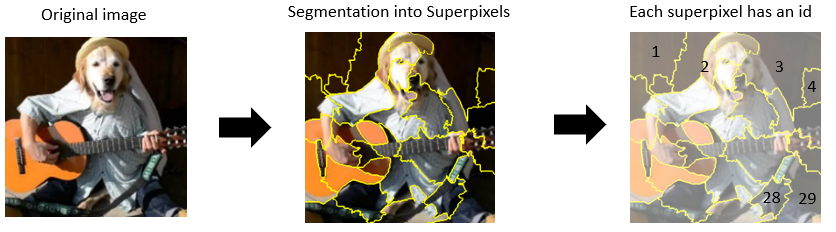

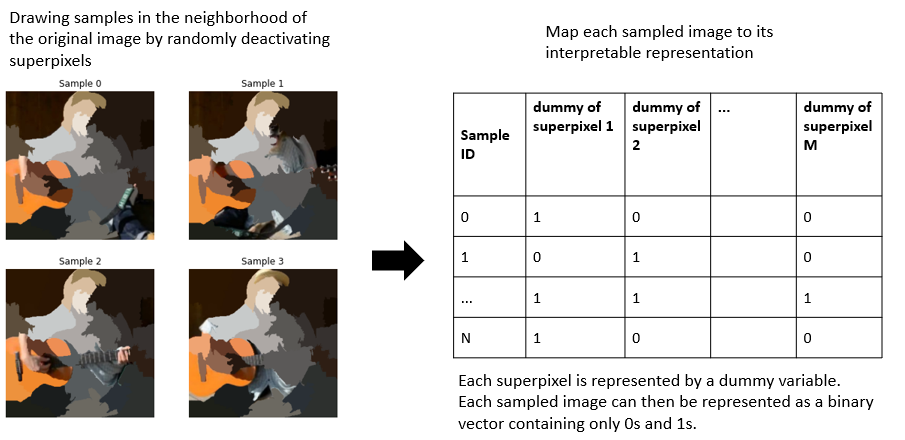

### Step 1: Interpretable representation of our original image

The idea of LIME is to map the original image $x_i$ to a simpler, easy-to-understand representation.

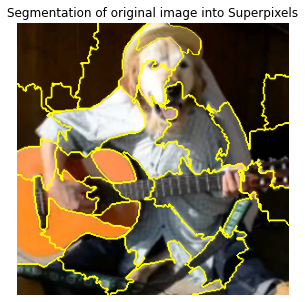

In [74]:
# segment original image into superpixels
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries

img_arr = np.asarray(img, dtype="uint8")

masks = quickshift(
    img_arr,
    kernel_size=6,
    max_dist=300,
    ratio=0.5
)

plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(img_arr, masks))
plt.axis("off")
plt.title("Segmentation of original image into Superpixels")
plt.show()

In [96]:
superpixel_ids = np.unique(masks)

print(superpixel_ids)
print(len(superpixel_ids))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
29


In [101]:
# draw samples in the neighborhood of the original instance
n_samples = 10



samples = []
samples_deactivated_superpixels = []
samples_activated_superpixels = []
for i in range(n_samples):
    n_deactivated_superpixels = round(len(superpixel_ids)*0.8)
    
    # randomly determine which superpixels to deactivate
    deactivated_superpixels = np.random.choice(superpixel_ids, size=n_deactivated_superpixels, replace=False)
    activated_superpixels = superpixel_ids[np.isin(superpixel_ids, deactivated_superpixels, invert=True)]
    
    # Replace superpixels with the superpixel's mean color
    sample = img_arr.copy()
    for superpixel in deactivated_superpixels:
        sample[masks == superpixel] = (
            np.mean(sample[masks == superpixel][:, 0]), # R Channel
            np.mean(sample[masks == superpixel][:, 1]), # B Channel
            np.mean(sample[masks == superpixel][:, 2]), # G Channel
        )
    
    samples.append(sample)
    samples_deactivated_superpixels.append(deactivated_superpixels)
    samples_activated_superpixels.append(activated_superpixels)
    
samples = np.array(samples)
print(samples.shape)

(10, 299, 299, 3)


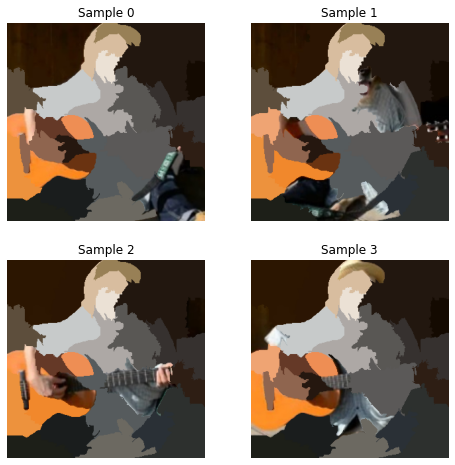

In [104]:
# examples of sampled images
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(axs.ravel()):
    s = samples[i, :, :]
    ax.imshow(s)
    ax.set_title(f"Sample {i}")
    ax.axis("off")

### Preparing dataset and labels to train the interpretable classifier

Our interpretable "glassbox" classifier will approximate the behavior of our blackbox classifier *locally*, that is, near our to-be-explained instance $x_i$.

We already have defined the area near $x_i$ through our sampled images. How does the blackbox classifier behave in that area? To answer this question, we use the blackbox classifier to *predict* the classes of our sampled images. These predictions will then become the *targets* of our interpretable classifier. This way, we get an interpretable classifier that imitates the behavior (the predictions) of the blackbox classifier.

The interpretable classifier is trained on an *interpretable representation* of our sampled images. We transform each sampled image from a `299x299x3` into a binary vector of size `n_superpixels`.

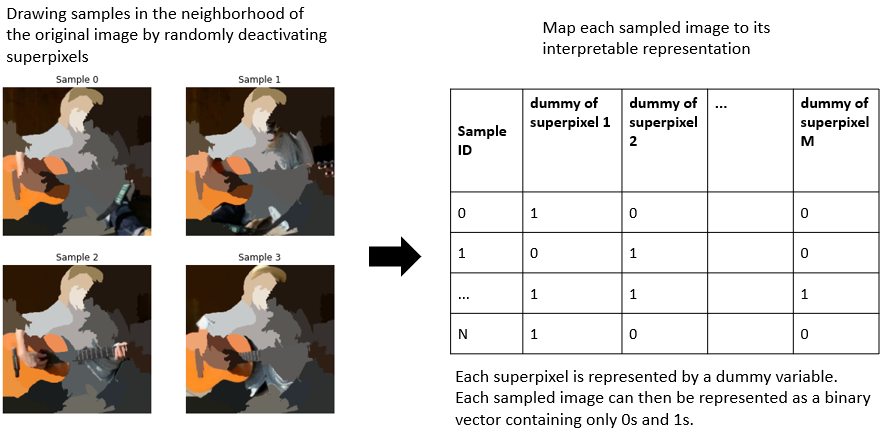

In [118]:
# Create dataset for interpretable classifier
X_simple = np.zeros(shape=(n_samples, len(superpixel_ids)))

for i in range(n_samples):
    activated_superpixels = samples_activated_superpixels[i]
    for sp in activated_superpixels:
        X_simple[i, sp] = 1
        
X_simple.shape

(10, 29)

In [117]:
# Create labels for interpretable classifier
X_samples = tf.convert_to_tensor(samples.astype("float32"))
X_samples = tf.keras.applications.inception_v3.preprocess_input(X_samples, data_format=None)
out_samples = model(X_samples)

y_simple = tf.argmax(out_samples, axis=1).numpy()
y_simple.shape

(10,)

In [121]:
# fit simple/interpretable classifier
from sklearn.linear_model import Ridge, lars_path

simple_model = Ridge(alpha=1, fit_intercept=True)
simple_model.fit(X_simple, y_simple) # add sample_weight parameter

prediction_score = simple_model.score(X_simple, y_simple)
prediction_score

0.963929660590347

### Explaining the prediction

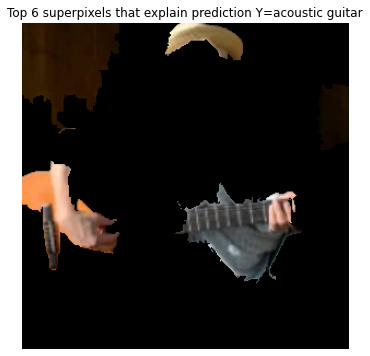

In [131]:
# explain prediction
superpixels_effects = sorted(
    zip(np.arange(len(superpixel_ids)), simple_model.coef_),
#     key=lambda x: np.abs(x[1]),
    key=lambda x: x[1],
    reverse=True
)

# show the top n contributing superpixels
top_n = 6
top_n_superpixels = [superpixel for (superpixel, effect_size) in superpixels_effects[:top_n]]
other_segments = superpixel_ids[np.isin(superpixel_ids, top_n_superpixels, invert=True)]

explainer = img_arr.copy()
for i in other_segments:
    explainer[masks == i] = 0 # replace with black


plt.figure(figsize=(6, 6))
plt.imshow(explainer)
plt.axis("off")
plt.title(f"Top {top_n} superpixels that explain prediction Y={imagenet_classes.iloc[class_idxs[0], 1]}")
plt.show()